Success in graduate school is all about learning. This isn't exactly news, but I think that the types of learning that contribute most to success aren't what one would expect from the outside. In popular presentation, a grad student's job is to learn everything there is to know about one extremely narrow topic, and eventually push the boundaries of human knowledge a tiny bit [farther out](http://matt.might.net/articles/phd-school-in-pictures/). Being a good graduate student certainly requires that you learn the main research results of your field, however as I've spent more time in grad school I've come to understand that knowing the human context surrounding research results is equally important. Identifying potential collaborators (or competitors) who are working on similar problems can have a huge impact. Likewise, knowing what types of problems are currently in vogue can acutely affect a grad student's academic prospects. As much as professors like to tout the intellectual freedom of academic research, people who sail with the prevailing winds go farthest.

This sort of contextual information doesn't come easily. Graduate advisors can convey some of what they know, but most learning in grad school is self-directed. What grad students learn on their own is typically absorbed haphazardly through article author bylines, Google Scholar searches, and research group websites. Given the volume of contemporary scientific output and the limited bandwidth of most students, this necessarily results in a shallow and imprecise view of the field. This brings us to the point of this post: having encountered this problem myself I'm going to try to extract some contextual information about my own field (condensed matter physics) from web scraped data.

Condensed matter physicists have one main conference every year. Conveniently for our purposes, the title, abstract, and authors of every talk given at the conference in the past decade are available online. The titles and authors can be scraped in bulk so that's what we'll be working with. A similar analysis could be done for other fields given similar data (for example, the authors and titles of peer-reviewed journal articles); unfortunately this data is somewhat hard to come by since publishing companies are a little touchy about people scraping their websites. If you're interested in condensed matter physics though the data used in this analysis is available [here]({{ BASE_PATH }}/data/marchmeeting.tar.gz).

In [196]:
%matplotlib inline

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from networkx.readwrite import json_graph

sns.set_context('talk')
pd.set_option('display.width', 120)

The data is in a separate file for each year, so we'll pull in all the pieces, concatenate them, and then clean up the data a little bit.

In [2]:
# read the data from file, store in df_all
files = ['MAR{:02}_titles.csv'.format(yr) for yr in range(5,16)]
pieces = [pd.read_csv(file, index_col=0) for file in files]

# clean the imported data a little bit
df_all = pd.concat(pieces).dropna()
df_all = df_all.loc[df_all.abs_authors!='Invited Speaker:']
df_all = df_all.loc[df_all.abs_authors!='']
df_all.abs_title = df_all.abs_title.str.strip()
df_all.abs_authors = df_all.abs_authors.str.strip('*')

# standardize capitalization
df_all.abs_authors = df_all.abs_authors.str.lower().str.title()

In [3]:
# add a column containing the year
def extract_year(url):
    return 2000+ int(url.split('/')[2][-2:])

df_all['year'] = df_all.abs_url.apply(extract_year)

After pre-processing our data looks like this:

In [197]:
print(df_all.head())

     abs_authors                                          abs_title                      abs_url  year
1      Keiji Ono  Nuclear Spin Induced Oscillatory Current in Sp...  /Meeting/MAR05/Session/A1.1  2005
1        Go Yusa  Electron-nuclear spin coupling in nano-scale d...  /Meeting/MAR05/Session/A1.2  2005
1     Xuedong Hu  Nuclear spin polarization and coherence in sem...  /Meeting/MAR05/Session/A1.3  2005
1  Mikhail Lukin  Controlling Nuclear Spin Environment of Quantu...  /Meeting/MAR05/Session/A1.4  2005
1  Silke Paschen  Hall effect indicates destruction of large Fer...  /Meeting/MAR05/Session/A2.1  2005


## Term popularity by year

As a first step, let's analyze the popularity of a few of the most common terms in abstract titles using scikit-learn's [CountVectorizer](http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage). This class takes a list of strings, for example abstract titles, and returns a matrix where each row corresponds to an abstract title and each column corresponds to a single word. The *(i, j)-*th entry of the matrix is the number of times word *j* appears in abstract *i*. By summing over all the rows we can get a count of how many times each word shows up across all abstract titles. If we separate the titles by year, and repeat the analysis for each year we can compare the relative popularity of different terms over the past decade.

In [5]:
# train a vectorizer on all the abstracts
all_titles = df_all.abs_title.unique()
total_vectorizer = CountVectorizer(stop_words='english').fit(all_titles)

# returns the count vector for a subset of the abstract titles
def get_count_vector(titles, vectorizer):
    return vectorizer.transform(titles).sum(axis=0)

The code above handles the term counting; next we'll split the abstracts up by year and count each subset individually.

In [6]:
def get_yearly_slices(df_all, vectorizer):
    slices = []

    for year in df_all.year.unique():
        year_titles = df_all.loc[df_all.year==year].abs_title.unique()
        c_vec = get_count_vector(year_titles, vectorizer)
        slices.append(pd.DataFrame(c_vec))
        
    return slices

Finally we pull everything into a pandas DataFrame and tidy things up a bit.

In [7]:
def get_yearly_counts(df_all, vectorizer):
    # collect the counts from each year in a dataframe
    yearly_counts = pd.concat(get_yearly_slices(df_all, vectorizer))
    yearly_counts.index = list(range(2005,2016))

    # change column titles from word index (a number) to the actual word
    word_index = pd.Series(vectorizer.vocabulary_, name='index_row')
    word_index.index.name = 'word'
    yearly_counts.columns = word_index.reset_index().word.values

    # add sum columns for normalizing
    yearly_counts['total_words'] = yearly_counts.sum(axis=1)
    yearly_counts['total_titles'] = df_all.drop_duplicates(subset='abs_title').groupby('year').count().abs_title
    
    # add sum row for sorting
    total_counts = yearly_counts.sum()
    total_counts.name = 'total_counts'
    yearly_counts = yearly_counts.append(total_counts)
    
    return yearly_counts

yearly_counts = get_yearly_counts(df_all, total_vectorizer)

After counting the occurences of each individual word for each year we end up with data that looks like this:

In [199]:
print(yearly_counts.transpose().sort_values(2015, ascending=False).head(10))

               2005   2006   2007   2008   2009   2010   2011   2012   2013   2014   2015  total_counts
total_words   48797  52772  52367  52464  54423  57558  58921  69717  67202  71277  70511        656009
total_titles   6347   6856   6742   6767   6953   7288   7433   8733   8204   8722   8601         82646
quantum         572    548    582    552    597    630    658    793    788    841    804          7365
spin            445    439    465    476    469    530    567    684    680    738    734          6227
graphene          5     31    105    246    322    437    504    577    561    552    496          3836
magnetic        462    422    430    427    451    465    448    517    474    496    488          5080
dynamics        289    313    352    328    291    341    355    388    356    440    456          3909
properties      331    388    365    374    324    385    379    404    402    445    445          4242
effect          298    275    277    291    295    322    297   

Let's take a look at the trends for a couple terms.

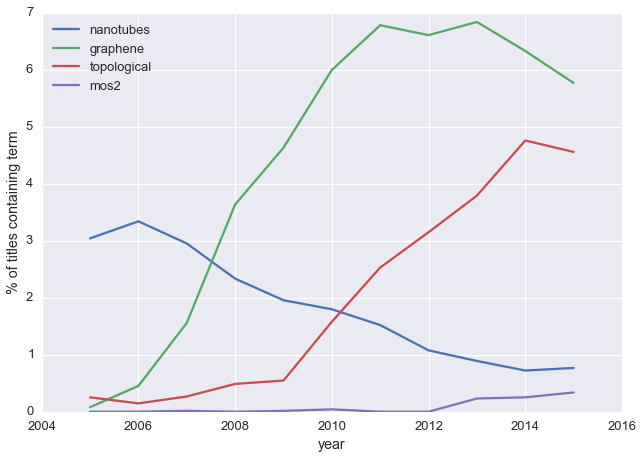

In [23]:
def plot_freq(term_list, df_counts):
    years = df_counts.index.values[:-1] 

    for term in term_list:   
        plt.plot(years, 100* df_counts[term].ix[years] / df_counts['total_titles'].ix[years], label=term)
        plt.xlabel('year')
        plt.ylabel('% of titles containing term')
        
    plt.legend(loc='best')

# plot the normalized frequency of a few different words
topics = ['nanotubes', 'graphene','topological', 'mos2']
plot_freq(topics, yearly_counts)

This broadly tracks with what I know about the field:

- carbon nanotubes were hot stuff 10-15 years ago, but are a bit passé now
- graphene first showed up in 2004, blew up for a couple years, but now interest is fading
- these days the cool kids are looking at new 2D materials like MoS\\(_2\\) and 'topological' materials

So far we're just confirming pre-existing impressions; what if we want to discover new trends without knowing what terms to search for? One simple option is to make a heatmap of term frequency versus year. Here we'll do that for the 25 most common single words and the 25 most common two-word tuples:

In [24]:
# count two word tuples
tuple_vectorizer = CountVectorizer(stop_words='english', min_df=5, ngram_range=(2,2)).fit(all_titles)
yearly_tuples_cts = get_yearly_counts(df_all, tuple_vectorizer)

/home/jhenri/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


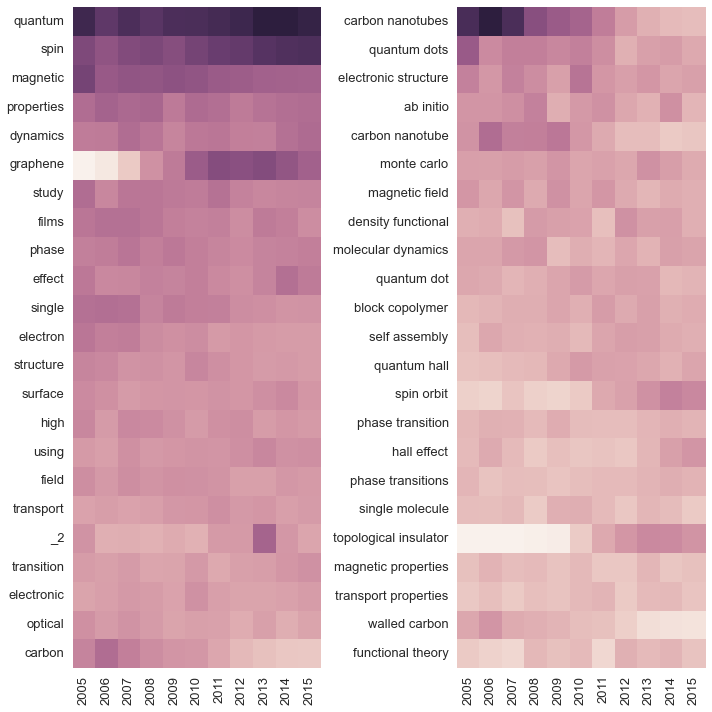

In [25]:
year_cols = list(range(2005,2016))

# find the top single and two-word terms by total count across all years
top_single = yearly_counts.transpose().sort_values('total_counts', ascending=False).head(1000)[year_cols]
top_tuple = yearly_tuples_cts.transpose().sort_values('total_counts', ascending=False).head(1000)[year_cols]

# plot heatmaps
fig, axes = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(top_single.div(top_single.ix['total_titles']).iloc[2:25], cbar=False, ax=axes[0])
sns.heatmap(top_tuple.div(top_tuple.ix['total_titles']).iloc[2:25], cbar=False, ax=axes[1])
fig.tight_layout()

The heatmaps convey the same information we plotted above (topological insulators are hot, carbon nanotubes are not), but they also expose a new trend: studies of spin orbit interactions are just as popular as topogical insulators. This is exactly the kind of contextual information that it's useful to have: knowing what is popular, I can search for the specific subject and read a few of the most important papers on the topic. This leaves me much better informed about the state of the field than reading a smattering of papers from the top journals.

So far we've addresssed the broad outlines of the field, but as a grad student I'm more often concerned with the small subset of the field that's directly related to my own research. Next let's identify those researchers whose work is most similar to my own.

## Similar authors

To find researchers working on similar work we're going to use a word counting approach similar to the one we used above. However, this time around we'll group the abstract titles by author instead of by year.

In [170]:
def concat_titles(titles):
    return ' '.join(titles)

df_auth_titles = df_all[['abs_authors','abs_title']]

df_authors = df_auth_titles.groupby('abs_authors').count()
df_authors.columns = ['num_abstracts']
df_authors['concat_titles'] = df_auth_titles.groupby('abs_authors')['abs_title'].apply(concat_titles).values

# limit to authors with more than 1 abstract
# otherwise overly sensitive to authors w just one abstract
df_compare = df_authors.loc[df_authors.num_abstracts>1]

Note that we're removing all authors who only show up on one abstract. Without this filtering the similar author list is often dominated by a single relevant abstract title. After re-arranging, our data looks like this:

In [200]:
print(df_compare.iloc[3000:3005])

                   num_abstracts                                      concat_titles
abs_authors                                                                        
Andrey F. Vilesov              4  Infrared spectra and intensities of H$_{2}$O-N...
Andrey Gromov                  8  Exact soliton solutions in a many-body system ...
Andrey Ignatov                 2  Nanoelectrical probing with multiprobe SPM Sys...
Andrey Iljin                   3  Light sensitive liquid crystals: Focusing on s...
Andrey Kiselev                 4  Measurement of the Spin Relaxation Lifetime (T...


Previously we were interested in the raw frequencies of different terms. Now we want to assess the similarity of two sets of words (those in the titles of two different authors' abstracts). We could simply compare the frequency of each word between the two authors (i.e. take the inner product of the count vectors for both authors), however this method would likely be dominated by a few common words. Instead, we need some way to weigh the importance of each word so that rarer words carry more weight.

One popular solution to this problem is to use [term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighting. The wikipedia link gives a thorough explanation, but to summarize, the weighting is determined by:

- term frequency: how often the term appears in a given author's abstract titles
- inverse document frequency: how often the term appears in all the titles

Scikit-learn has a ready-made [class](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) which we'll use to transform the data according to this weighting.

In [172]:
# vectorize the words in all the abstract titles
auth_vectorizer = CountVectorizer(stop_words='english', min_df=5, ngram_range=(1,2)).fit(all_titles)
auth_vectors = auth_vectorizer.transform(df_compare.concat_titles)

In [173]:
# transform the count vectors to tfidf vectors
transformer = TfidfTransformer()
auth_tfidf = transformer.fit_transform(auth_vectors)

Now that we have an appropriately weighted count matrix, we can find similar authors by taking the dot product of the count matrix and a count vector corresponding to terms that we care about.

In [174]:
def similar_authors(title, n_matches, tfidf, vectorizer):
    # title must be in a list, otherwise vectorizer splits it into characters instead of words
    if type(title) is not list:
        title = [title]
    
    title_vector = vectorizer.transform(title)
    
    # calculate cosine similarity of the title vector with each author's vector
    distances = tfidf.dot(title_vector.transpose())
    # reshape to 1d array
    distances = distances.toarray().reshape(tfidf.shape[0],)
    # find the indices of the n_matches smallest distances  
    best_matches = np.argsort(distances)[-n_matches:][::-1]
    
    return best_matches

As a test, let's find authors whose work is similar to my most recently submitted paper, which is titled 'Single Gate P-N Junctions in Graphene-Ferroelectric Devices'.

In [201]:
title = 'single gate p-n junctions in graphene ferroelectric devices'
indices = similar_authors(title, 10, auth_tfidf, auth_vectorizer)
df_similar = df_compare.iloc[indices]
print(df_similar)

                    num_abstracts                                      concat_titles
abs_authors                                                                         
J. Henry Hinnefeld              3  Strain Effects in Graphene Transport Measureme...
Ruijuan Xu                      3  Scanned Probe Measurements of Graphene on Ferr...
Mohammed Yusuf                  4  Characterization Of Graphene-Ferroelectric Sup...
Xu Du                          26  Bragg Spectroscopy of Excitations of a Quantum...
Maria Moura                     2           Rippling of Graphene Tearing of Graphene
Chunning Lau                   10  Supercurrent in Graphene Josephson Transistors...
Gang Liu                       20  Nano-meter structured three-phase contact line...
Wenzhong Bao                   45  Thermopower of Few-Layer Graphene Devices Spin...
Philip Kim                    128  Electric Transport in MoSe molecular Nanowires...
Chun Ning Lau                  36  Scanned Probe Imaging of Nanos

Looks pretty good -- the two most similar researchers are myself and my collaborator. I recognize some of the other names, for example Philip Kim is one of the two or three biggest names in graphene research. Several of the other names are a mystery to me though. As a final step, let's use some graph-based analyses to figure out the context surrounding these other researchers.

## Graph-based analysis

We'll start by building a graph of all coauthors of the 10 most similar authors. 

For each author in the graph we'll add edges joining that author to anyone else in the graph with whom they have been coauthors. Having populated our graph, I'll borrow some D3.js code from [here](http://www.unc.edu/~ncaren/cite_network_full/cites.html) to visualize the graph and look for relationships between the similar authors.

In [128]:
# make a dict to colorize the similar authors in the graph
color_dict = defaultdict(lambda: 0)
for author in df_similar.index.values:
    color_dict[author]=1

In [180]:
def add_author(graph, author):
    # add a node for the author if there isn't one already
    if author not in graph.nodes():
        n_abstracts = df_authors.ix[author].num_abstracts
        graph.add_node(author, group=color_dict[author], nodeSize=np.sqrt(n_abstracts)+5)
    
def add_coauthors(graph, author, df_all, color_dict):
    # get the titles of all abstracts authored by 'author'
    titles = df_all.loc[df_all.abs_authors==author].abs_title.values
    # get the other authors on those abstracts
    coauthors = list(df_all.loc[df_all.abs_title.isin(titles)].abs_authors.unique())
    coauthors.remove(author)

    for coauthor in coauthors:
        add_author(graph, coauthor)
        # add an edge between author-coauthor for this paper, if there isn't one
        if (author, coauthor) not in graph.edges() and (coauthor, author) not in graph.edges():
            graph.add_edge(author, coauthor)

base_graph = nx.Graph()

for author in df_similar.index.values:
    add_author(base_graph, author)
    add_coauthors(base_graph, author, df_all, color_dict)

In [181]:
with open('network.json', 'w') as outfile:
    data = json_graph.node_link_data(base_graph)
    #s = json.dumps(data, sort_keys=True, indent=4, separators=(',', ': '))
    s = json.dumps(data)
    outfile.write(s)

In the figure below, each circle corresponds to an author, and the size of each circle indicates how many abstracts list that author as a contributor.

!['graph'](network.png)

A few things are immediately apparent:

- Philip Kim is a big deal.
- Wenzhong Bao, Chun Ning Lau, and Gang Liu work together closely. They also have strong ties to Philip Kim.
- A few other groups work largely independently.

This is exactly the kind of contextual information that I want to know but that is hard to acquire directly.

The Jupyter notebook for this post is [here](/notebooks/marchmeeting.ipynb) and the data is [here](/data/marchmeeting.tar.gz)